In [1]:
# from gen_results import metric
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
def metric(seeds_dir, error_name='l1', verbose=False):
    # average of last 10 epochs
    results_path = Path(seeds_dir)

    if verbose:
        print(results_path.name)

    run_logs = []
    for path in results_path.glob('*/logs.json'):
        if verbose:
            print(path)
        with open(path, 'r') as logfile:
            try:
                run_logs.append(pd.read_json(logfile))
            except ValueError as e:
                raise ValueError(f'cant read json {path}: {e}')

    if not run_logs:
        return None

    logs = pd.concat(run_logs, ignore_index=True)
    epoch = logs['epoch']
    sender = pd.DataFrame(logs['sender'].tolist()).join(logs['epoch'])
    recver = pd.DataFrame(logs['recver'].tolist()).join(logs['epoch'])
    if error_name == 'l1' and 'test_l1_error' in sender:
        error_metric = 'test_l1_error'
    elif error_name == 'l2' and 'test_l2_error' in sender:
        error_metric = 'test_l2_error'
    elif error_name == 'train':
        error_metric = 'test_error'
    else:
        raise Exception(f'error name {error_name} either not found or not valid')

    last_10 = logs['epoch'] >= 20
    return sender[last_10][error_metric].mean(), recver[last_10][error_metric].mean()


def all_metrics(path):
    all_results_path = Path(path)

    sender_l1 = []
    recver_l1 = []
    errors = []
    for result_dir in all_results_path.iterdir():
        if result_dir.is_dir():
#             print(f'working on {result_dir}')
            try:
                s1, r1 = metric(result_dir)
            except:
                errors.append(result_dir.name)
            else:
                sender_l1.append(s1*10)
                recver_l1.append(r1*10)
    
    return sender_l1, recver_l1

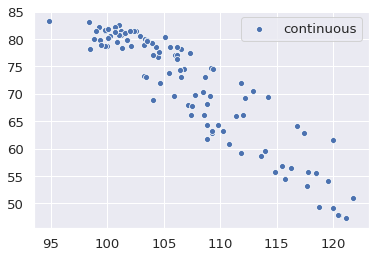

In [5]:
for bias in [0,3,6,9,12,15]:
    with sns.plotting_context('paper'):
        path = '/home/mnoukhov/emergent-selfish/full_logs/gauss-deter-50-bias15'
        sender_l1, recver_l1 = all_metrics(path)
        sns.set(font_scale=1.2)
        sns.scatterplot(sender_l1,recver_l1, label='continuous')

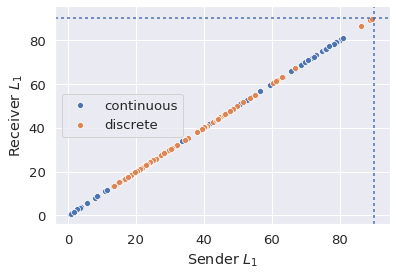

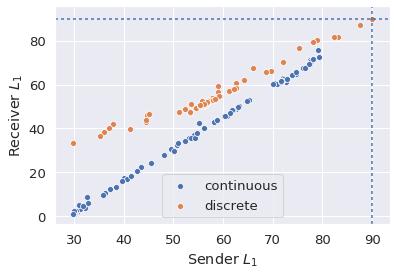

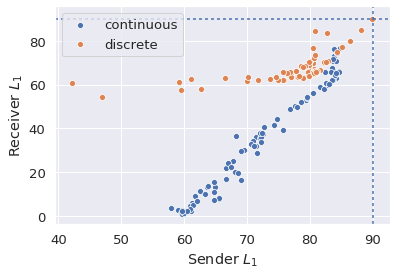

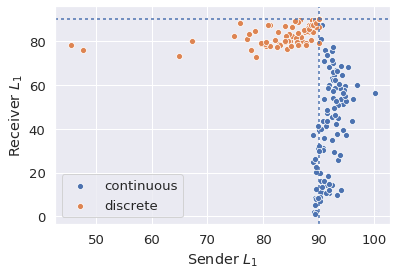

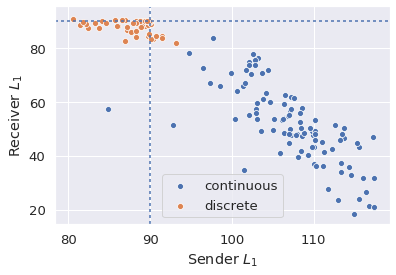

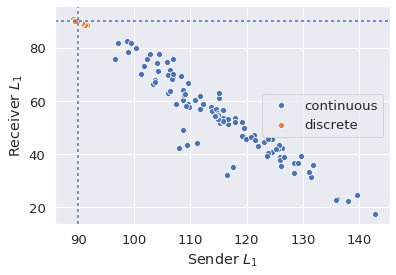

In [9]:
for bias in [0,3,6,9,12,15]:
    with sns.plotting_context('paper'):
        path = f'/home/mnoukhov/emergent-selfish/full_logs/gauss-deter-3-bias{bias}'
        sender_l1, recver_l1 = all_metrics(path)
        sns.set(font_scale=1.2)
        sns.scatterplot(sender_l1,recver_l1, label='continuous')
        plt.xlabel(r'Sender $L_1$')
        plt.ylabel(r'Receiver $L_1$')

        path = f'/home/mnoukhov/emergent-selfish/full_logs/cat-deter-bias{bias}'
        sender_l1, recver_l1 = all_metrics(path)
        sns.set(font_scale=1.2)
        sns.scatterplot(sender_l1,recver_l1, label='discrete')
        plt.xlabel(r'Sender $L_1$')
        plt.ylabel(r'Receiver $L_1$')

        plt.axvline(90, dashes=(2,2,2,2))
        plt.axhline(90, dashes=(2,2,2,2))

        plt.savefig(f'../full_logs/cont_v_discrete_bias{bias}.png',  bbox_inches='tight')
        plt.show()

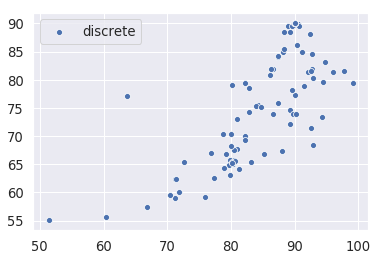

In [35]:
with sns.plotting_context('paper'):
    path = '/home/mnoukhov/emergent-selfish/results/continuous/senderlola1-recverlola1-bias6'
    sender_l1, recver_l1 = all_metrics(path)
    sns.set(font_scale=1.2)
    sns.scatterplot(sender_l1,recver_l1, label='discrete')

#     path = '/home/mnoukhov/emergent-selfish/results/continuous/senderlola2-recverlola2-bias9'
#     sender_l1, recver_l1 = all_metrics(path)
#     sns.set(font_scale=1.2)
#     sns.scatterplot(sender_l1,recver_l1, label='discrete')
#     plt.xlabel(r'Sender $L_1$')
#     plt.ylabel(r'Receiver $L_1$')

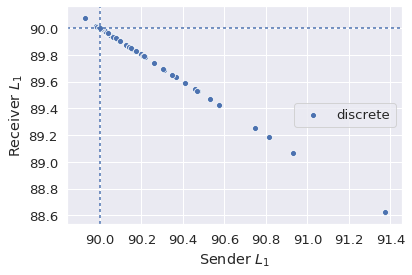

In [12]:
path = '/home/mnoukhov/emergent-selfish/full_logs/cat-deter-bias18'
with sns.plotting_context('paper'):
    sender_l1, recver_l1 = all_metrics(path)
    sns.set(font_scale=1.2)
    sns.scatterplot(sender_l1,recver_l1, label='discrete')
    plt.xlabel(r'Sender $L_1$')
    plt.ylabel(r'Receiver $L_1$')
    
#     path = '/home/mnoukhov/emergent-selfish/results/continuous/senderlola1-recverlola1-bias9'
#     sender_l1, recver_l1 = all_metrics(path)
#     sns.set(font_scale=1.2)
#     sns.scatterplot(sender_l1,recver_l1, label='discrete-LOLA')
#     plt.xlabel(r'Sender $L_1$')
#     plt.ylabel(r'Receiver $L_1$')
    
    plt.axvline(90, dashes=(2,2,2,2))
    plt.axhline(90, dashes=(2,2,2,2))

    
    plt.savefig(f'/home/mnoukhov/emergent-selfish/full_logs/cat-deter-bias18.png',  bbox_inches='tight')

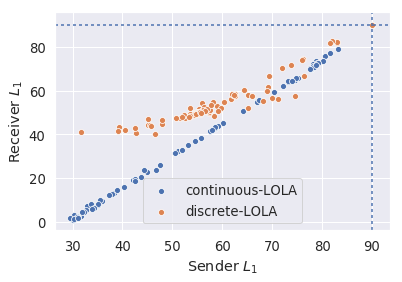

In [37]:
with sns.plotting_context('paper'):
    path = '/home/mnoukhov/emergent-selfish/results/continuous/gausslola1-recverlola1-bias3'
    sender_l1, recver_l1 = all_metrics(path)
    sns.set(font_scale=1.2)
    sns.scatterplot(sender_l1,recver_l1, label='continuous-LOLA')
    plt.xlabel(r'Sender $L_1$')
    plt.ylabel(r'Receiver $L_1$')
    
    path = '/home/mnoukhov/emergent-selfish/results/continuous/senderlola1-recverlola1-bias3'
    sender_l1, recver_l1 = all_metrics(path)
    sns.set(font_scale=1.2)
    sns.scatterplot(sender_l1,recver_l1, label='discrete-LOLA')
    plt.xlabel(r'Sender $L_1$')
    plt.ylabel(r'Receiver $L_1$')
    
    plt.axvline(90, dashes=(2,2,2,2))
    plt.axhline(90, dashes=(2,2,2,2))

    
    plt.savefig(f'../results/continuous/discretelola-v-continuouslola-bias3.png',  bbox_inches='tight')

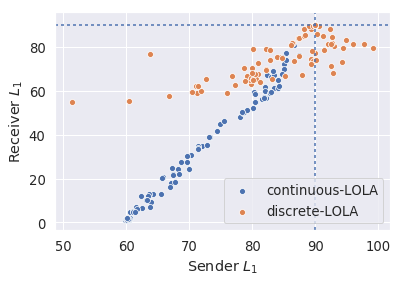

In [38]:
with sns.plotting_context('paper'):
    path = '/home/mnoukhov/emergent-selfish/results/continuous/gausslola1-recverlola1-bias6'
    sender_l1, recver_l1 = all_metrics(path)
    sns.set(font_scale=1.2)
    sns.scatterplot(sender_l1,recver_l1, label='continuous-LOLA')
    plt.xlabel(r'Sender $L_1$')
    plt.ylabel(r'Receiver $L_1$')
    
    path = '/home/mnoukhov/emergent-selfish/results/continuous/senderlola1-recverlola1-bias6'
    sender_l1, recver_l1 = all_metrics(path)
    sns.set(font_scale=1.2)
    sns.scatterplot(sender_l1,recver_l1, label='discrete-LOLA')
    plt.xlabel(r'Sender $L_1$')
    plt.ylabel(r'Receiver $L_1$')
    
    plt.axvline(90, dashes=(2,2,2,2))
    plt.axhline(90, dashes=(2,2,2,2))

    
    plt.savefig(f'../results/continuous/discretelola-v-continuouslola-bias6.png',  bbox_inches='tight')

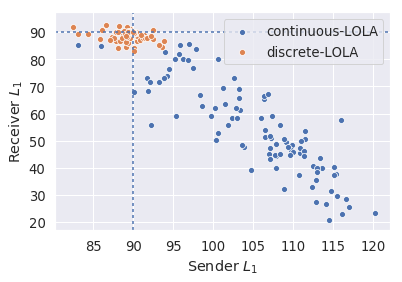

In [40]:
with sns.plotting_context('paper'):
    path = '/home/mnoukhov/emergent-selfish/results/continuous/gausslola1-recverlola1-bias12'
    sender_l1, recver_l1 = all_metrics(path)
    sns.set(font_scale=1.2)
    sns.scatterplot(sender_l1,recver_l1, label='continuous-LOLA')
    plt.xlabel(r'Sender $L_1$')
    plt.ylabel(r'Receiver $L_1$')
    
    path = '/home/mnoukhov/emergent-selfish/results/continuous/senderlola1-recverlola1-bias12'
    sender_l1, recver_l1 = all_metrics(path)
    sns.set(font_scale=1.2)
    sns.scatterplot(sender_l1,recver_l1, label='discrete-LOLA')
    plt.xlabel(r'Sender $L_1$')
    plt.ylabel(r'Receiver $L_1$')
    
    plt.axvline(90, dashes=(2,2,2,2))
    plt.axhline(90, dashes=(2,2,2,2))

    
    plt.savefig(f'../results/continuous/discretelola-v-continuouslola-bias12.png',  bbox_inches='tight')

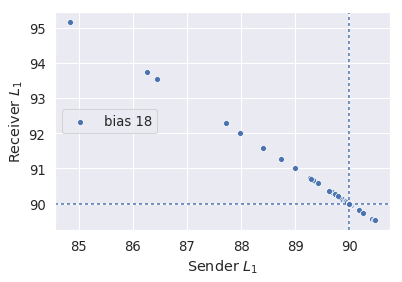

In [8]:
with sns.plotting_context('paper'):
    path = '/home/mnoukhov/emergent-selfish/results/continuous/cat-deter-bias18'
    sender_l1, recver_l1 = all_metrics(path)
    sns.set(font_scale=1.2)
    sns.scatterplot(sender_l1,recver_l1, label='bias 18')
    plt.xlabel(r'Sender $L_1$')
    plt.ylabel(r'Receiver $L_1$')
    
    plt.axvline(90, dashes=(2,2,2,2))
    plt.axhline(90, dashes=(2,2,2,2))
    
    plt.savefig(f'../results/continuous/cat-deter-bias18-hyperparam.png',  bbox_inches='tight')


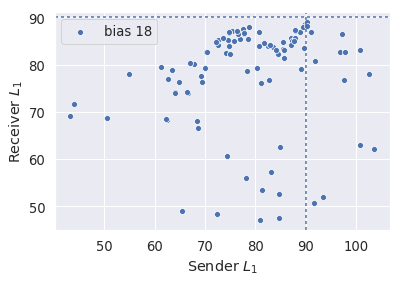

In [10]:
with sns.plotting_context('paper'):
    path = '/home/mnoukhov/emergent-selfish/results/continuous/cat-deter-onelayer-bias9'
    sender_l1, recver_l1 = all_metrics(path)
    sns.set(font_scale=1.2)
    sns.scatterplot(sender_l1,recver_l1, label='bias 18')
    plt.xlabel(r'Sender $L_1$')
    plt.ylabel(r'Receiver $L_1$')
    
    plt.axvline(90, dashes=(2,2,2,2))
    plt.axhline(90, dashes=(2,2,2,2))
    
    plt.savefig(f'../results/continuous/cat-deter-onelayer-bias9.png',  bbox_inches='tight')


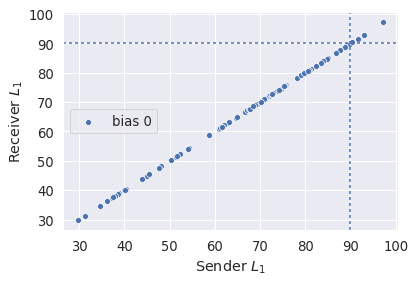

In [5]:
with sns.plotting_context('paper'):
    path = '/home/mnoukhov/emergent-selfish/full_logs/cat-deter-bias0'
    sender_l1, recver_l1 = all_metrics(path)
    sns.set(font_scale=1.2)
    sns.scatterplot(sender_l1,recver_l1, label='bias 0')
    plt.xlabel(r'Sender $L_1$')
    plt.ylabel(r'Receiver $L_1$')
    
    plt.axvline(90, dashes=(2,2,2,2))
    plt.axhline(90, dashes=(2,2,2,2))
    
#     plt.savefig(f'../results/continuous/cat-deter-onelayer-bias9.png',  bbox_inches='tight')